<font size="12">Exploring the datasets</font>

# Setting up

## Importing libraries

In [52]:
import pandas as pd
import pathlib
import keras
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from transformers import TFAutoModelForImageClassification, AutoImageProcessor

from sklearn.metrics import accuracy_score
from tensorflow.keras import layers, models, optimizers

from tensorflow.keras.applications import ResNet50, imagenet_utils
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications import DenseNet121

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, concatenate, UpSampling2D

## Importing data

In [5]:
url_normal = '../data/CT/Lung/normal/'

url_airspace = '../data/CT/Lung/Airspace_opacity/'
url_bronch = '../data/CT/Lung/Bronchiectasis/'
url_inter = '../data/CT/Lung/interstitial_lung_disease/'
url_nodule = '../data/CT/Lung/Nodule/'
url_parenchyma = '../data/CT/Lung/Parenchyma_destruction/'

In [6]:
limite = 100

In [7]:
images_normal = [cv2.imread(file) for file in glob.glob(url_normal+"*.png")]

In [8]:
images_airspace = [cv2.imread(file) for file in glob.glob(url_airspace+"*.png")][:limite]
images_bronch = [cv2.imread(file) for file in glob.glob(url_bronch+"*.png")][:limite]
images_inter = [cv2.imread(file) for file in glob.glob(url_inter+"*.png")][:limite]
images_nodule = [cv2.imread(file) for file in glob.glob(url_nodule+"*.png")][:limite]
images_parenchyma = [cv2.imread(file) for file in glob.glob(url_parenchyma+"*.png")][:limite]

In [10]:
labels_airspace = [5] * len(images_nodule)
labels_bronch = [3] * len(images_nodule)
labels_inter = [2] * len(images_nodule)
labels_nodule = [1] * len(images_nodule)
labels_parenchyma = [4] * len(images_nodule)

labels_normal = [0] * len(images_normal)

## Checking data

In [21]:
normal_count = len(images_normal)
normal_count

320

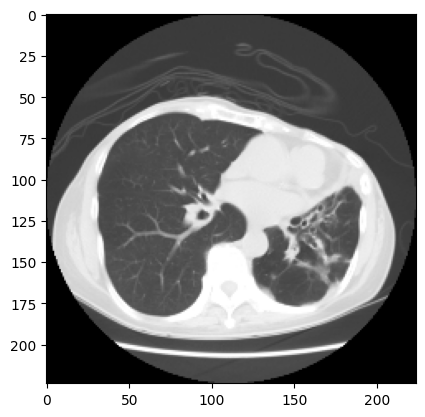

In [138]:
img = np.asarray(images_bronch[0])
imgplot = plt.imshow(img)

# Model definition

def initialize_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (4,4), activation="relu", input_shape=(224, 224, 3)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(32, (3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(64, (3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(128, (2,2), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(6, activation='softmax'))
    
      ### Model compilation
    model.compile(loss='sparse_categorical_crossentropy',
           optimizer='adam',
           metrics=['accuracy'])
    
    return model

def initialize_model():

    model = models.Sequential()

    model.add(layers.Conv2D(16, (7,7), activation="tanh", input_shape=(224, 224, 3)))
    model.add(layers.MaxPool2D(pool_size=(3,3)))
    
    model.add(layers.Conv2D(32, (4,4), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(3,3)))
    
    model.add(layers.Conv2D(64, (3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(128, (2,2), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(32, activation='relu'))

    model.add(layers.Dense(6, activation='softmax'))
    
    ### Model compilation
    model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
       
    
    return model

In [199]:
def create_pretrained_vgg16_model(input_shape=(224, 224, 3), num_classes=5):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

num_classes = 5

pretrained_vgg16_model = create_pretrained_vgg16_model(num_classes=num_classes)

pretrained_vgg16_model.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_38 (Flatten)        (None, 25088)             0         
                                                                 
 dense_80 (Dense)            (None, 512)               12845568  
                                                                 
 dense_81 (Dense)            (None, 5)                 2565      
                                                                 
Total params: 27562821 (105.14 MB)
Trainable params: 12848133 (49.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


# Loading Models

In [53]:
def unet_model(input_shape=(224, 224, 3)):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

    # Freeze the weights of the base model
    base_model.trainable = False

    # Get the output tensor from the base model
    base_model_output = base_model.output

    # Expansive Path
    up1 = concatenate([UpSampling2D(size=(2, 2))(base_model_output), base_model.get_layer('block_13_expand_relu').output], axis=-1)
    up1 = Conv2D(512, 3, activation='relu', padding='same')(up1)
    up1 = Conv2D(512, 3, activation='relu', padding='same')(up1)

    up2 = concatenate([UpSampling2D(size=(2, 2))(up1), base_model.get_layer('block_6_expand_relu').output], axis=-1)
    up2 = Conv2D(256, 3, activation='relu', padding='same')(up2)
    up2 = Conv2D(256, 3, activation='relu', padding='same')(up2)

    up3 = concatenate([UpSampling2D(size=(2, 2))(up2), base_model.get_layer('block_3_expand_relu').output], axis=-1)
    up3 = Conv2D(128, 3, activation='relu', padding='same')(up3)
    up3 = Conv2D(128, 3, activation='relu', padding='same')(up3)

    up4 = concatenate([UpSampling2D(size=(2, 2))(up3), base_model.get_layer('block_1_expand_relu').output], axis=-1)
    up4 = Conv2D(64, 3, activation='relu', padding='same')(up4)
    up4 = Conv2D(64, 3, activation='relu', padding='same')(up4)

    outputs = Conv2D(3, 1, activation='sigmoid')(up4)  # Adjust the number of output channels based on your needs

    model = Model(inputs=base_model.input, outputs=outputs)

    return model

# Create the model
base_model = unet_model()

9406464/9406464 [==============================] - 1s 0us/step


In [11]:
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = TFAutoModelForImageClassification.from_pretrained("microsoft/resnet-50")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
All model checkpoint layers were used when initializing TFResNetForImageClassification.

All the layers of TFResNetForImageClassification were initialized from the model checkpoint at microsoft/resnet-50.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFResNetForImageClassification for predictions without further training.


In [96]:
X = np.concatenate((images_bronch, images_inter, images_nodule, images_parenchyma, images_normal), axis=0)
y = np.concatenate((labels_bronch, labels_inter, labels_nodule, labels_parenchyma, labels_normal), axis=0)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

#base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))



for layer in base_model.layers:
    layer.trainable = False

x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)

x = layers.Dense(512, activation='relu')(x)

num_classes = 6
output_layer = layers.Dense(num_classes, activation='softmax')(x)

fine_tuned_model = models.Model(inputs=base_model.input, outputs=output_layer)

fine_tuned_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [97]:
history = fine_tuned_model.fit(
    preprocess_input(X_train),
    y_train,
    epochs=2,
    validation_data=(preprocess_input(X_val), y_val)
)

test_results = fine_tuned_model.evaluate(preprocess_input(X_test), y_test)
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

Epoch 1/2
18/18 [==============================] - 107s 6s/step - loss: 6.2012 - accuracy: 0.5278 - val_loss: 3.8990 - val_accuracy: 0.6111
Epoch 2/2
3/3 [==============================] - 12s 3s/step - loss: 5.0869 - accuracy: 0.5556
Test Loss: 5.086889266967773
Test Accuracy: 0.5555555820465088


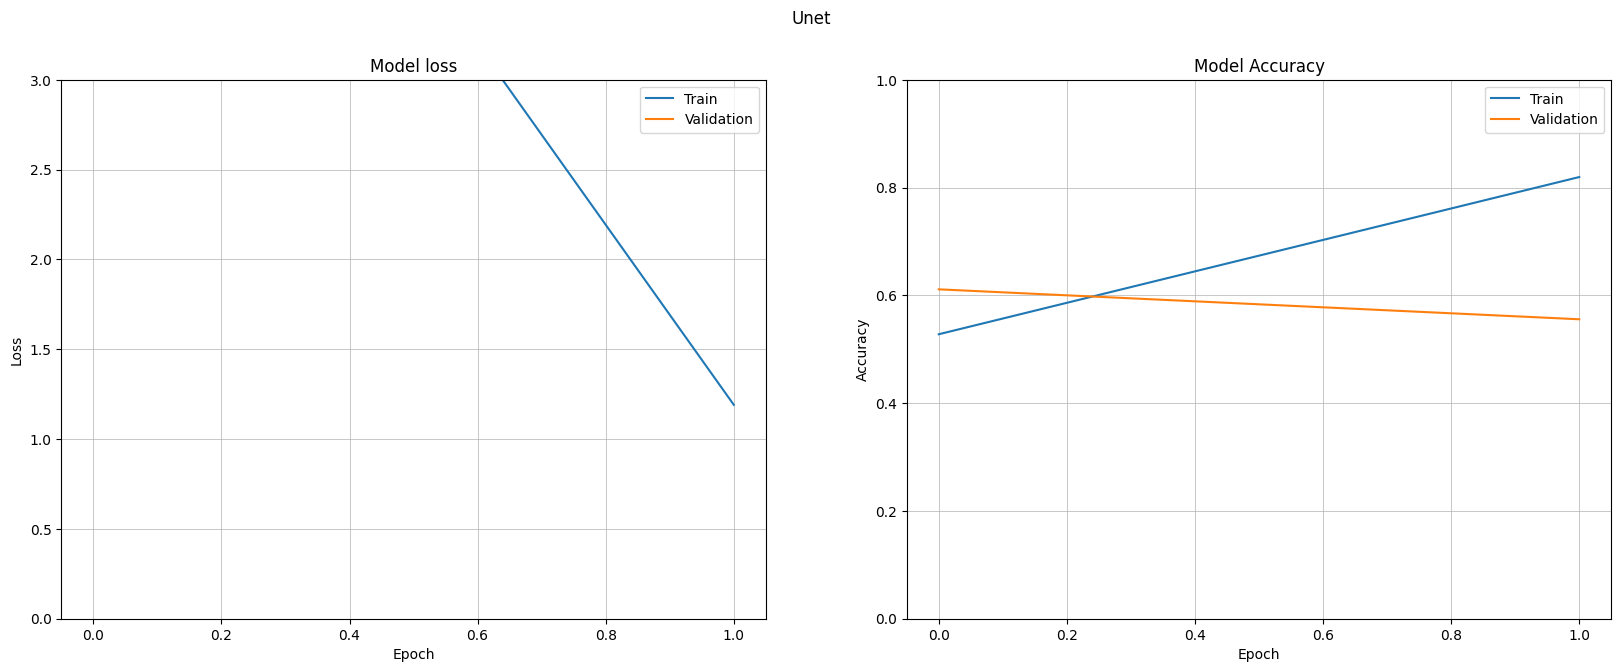

In [98]:
plot_loss_accuracy(history, title='Unet')

In [99]:
fine_tuned_model.summary()

Model: "model_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [103]:
#layer_names = ['input_5','bn_Conv1' 'Conv1_relu','block_1_expand_relu', 'block_2_expand_relu']
layer_names = ['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv1', 'block3_conv1']
#layer_names = ['conv1_conv', 'conv1_relu', 'conv2_block1_1_conv','conv2_block2_out', 'conv3_block1_1_conv']
#layer_names = ['input_6','conv1/conv','conv1/relu','conv2_block1_0_relu','conv2_block2_1_conv'] #DenseNet 121
#layer_names = ['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1'] #VGG + 512

layers_to_visualize = layer_names
number = 35
name = X_test[number]
test_image_array = np.asarray(name)

1/1 [==============================] - 0s 141ms/step


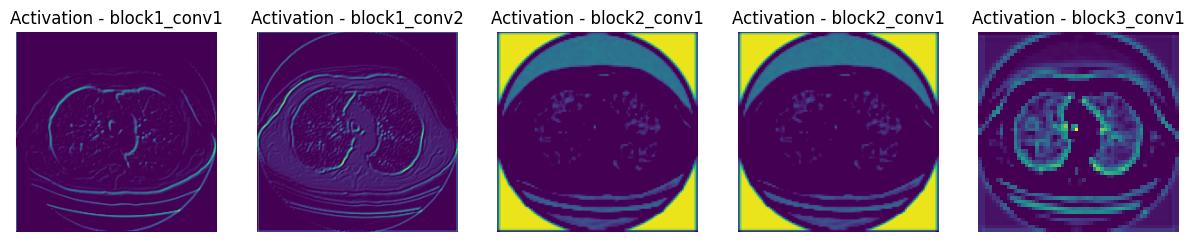

In [104]:
def visualize_activations(model, img_array, layers):

    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    outputs = [model.get_layer(layer).output for layer in layers]
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=outputs)

    activations = activation_model.predict(img_array)

    plt.figure(figsize=(15, 8))
    for i, activation in enumerate(activations):
        plt.subplot(1, len(layers), i + 1)
        plt.imshow(activation[0, :, :, 0], cmap='viridis')  # Adjust the indexing if needed
        plt.title(f'Activation - {layers[i]}')
        plt.axis('off')

    plt.show()

visualize_activations(fine_tuned_model, test_image_array, layers_to_visualize)

airspace = 5
bronch = 3
inter = 2
nodule = 1
parenchyma = 4

normal = 0

In [108]:
#VGG16, ResNet50
def generate_gradcam(model, img_array, layer_name):
    img_array = np.expand_dims(img_array, axis=0)
    grad_model = tf.keras.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        loss = predictions[:, 1]

    grads = tape.gradient(loss, conv_output)
    guided_grads = (tf.cast(conv_output > 0, "float32") * tf.cast(grads > 0, "float32") * grads)

    weights = tf.reduce_mean(guided_grads, axis=(0, 1, 2))
    cam = np.dot(conv_output[0], weights)

    return cam, conv_output, predictions

def plot_gradcam(model, img_array, layer_name, label, confidence):
    cam, _, _ = generate_gradcam(model, img_array, layer_name)
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_array)
    plt.title(f'Original Image: {label}{y[number]}\nConfidence: {confidence:.2%}')

    plt.subplot(1, 2, 2)
    plt.imshow(img_array[0], alpha=0.8)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title(f'GradCAM ({layer_name})')

    plt.show()

1/1 [==============================] - 0s 152ms/step
Predicted class: Bronch
Confidence: 95.42%
1


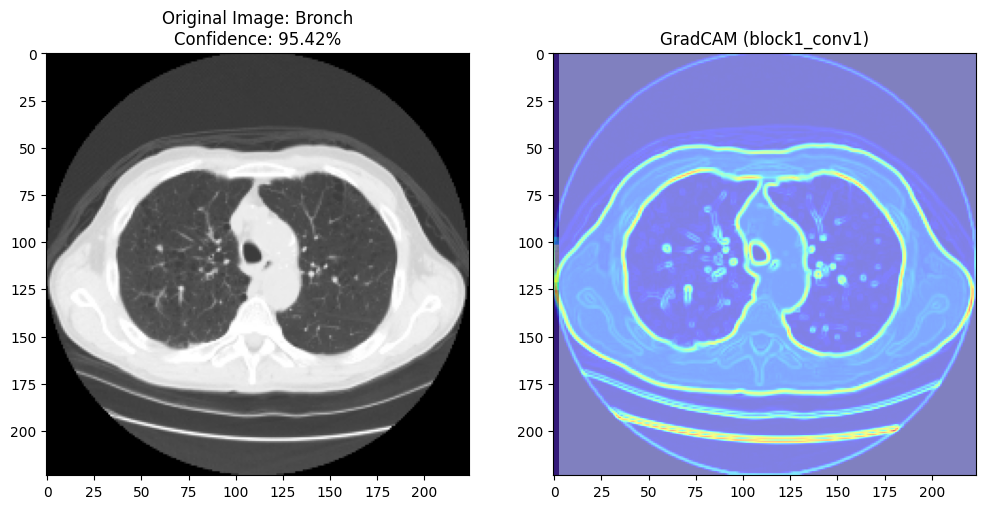

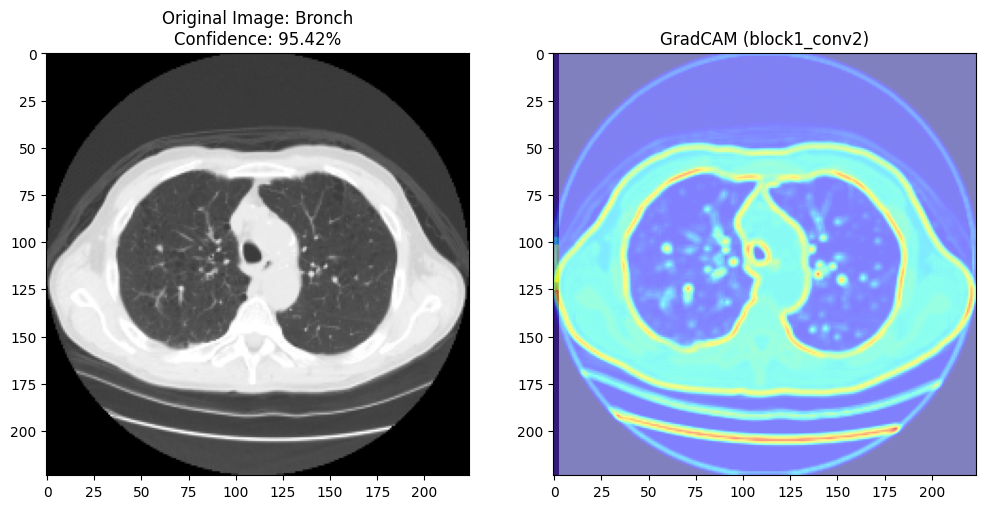

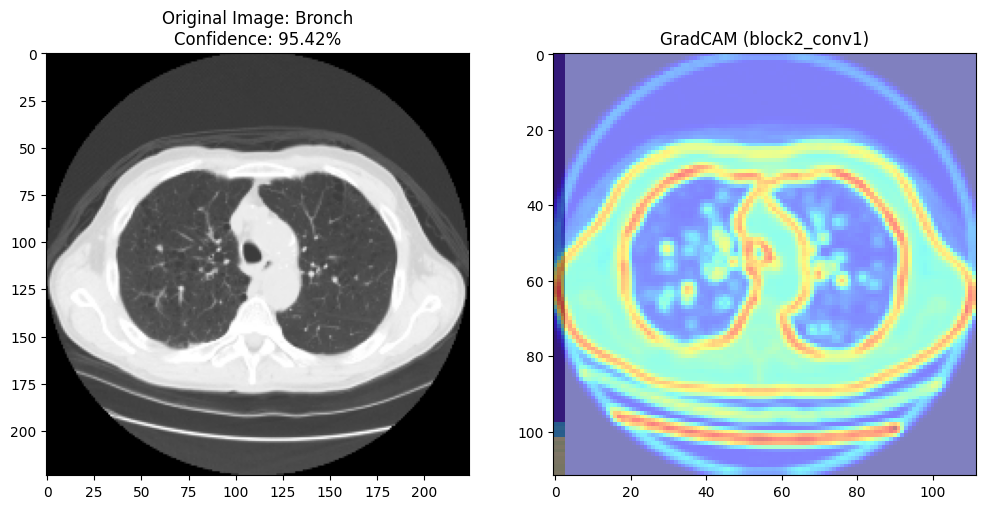

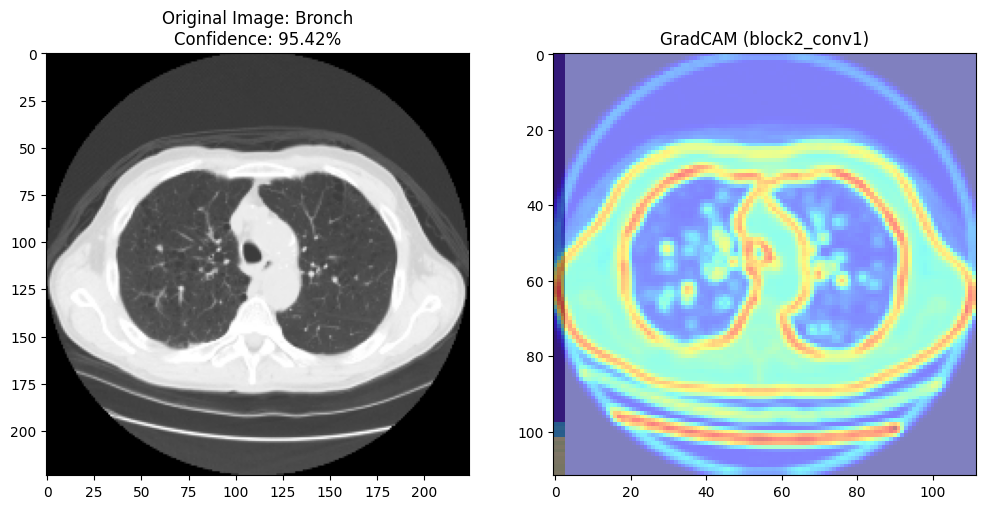

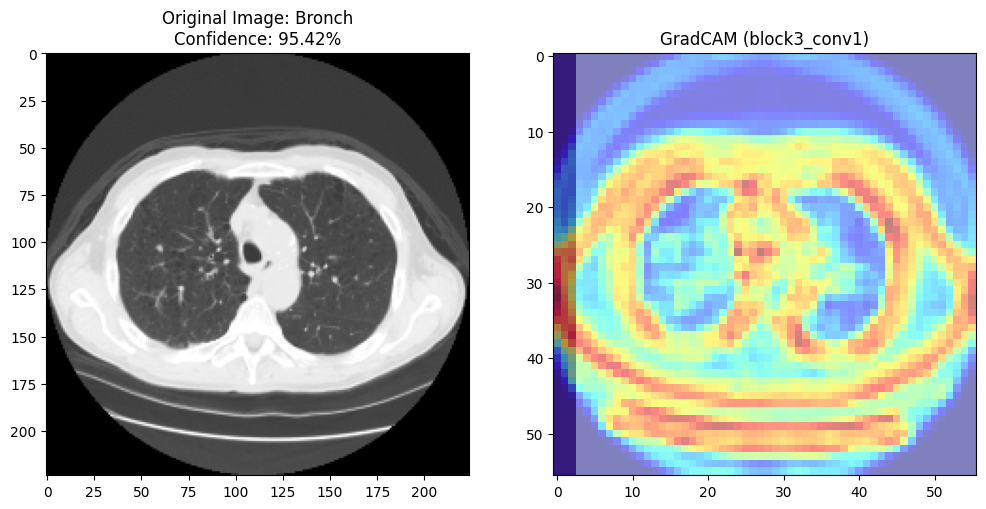

In [106]:
#Version 2 DenseNet 121
def generate_gradcam(model, img_array, layer_name):
    img_array = np.expand_dims(img_array, axis=0)
    grad_model = tf.keras.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        loss = predictions[:, 1]

    grads = tape.gradient(loss, conv_output)

    # Check if gradients are not None before proceeding
    if grads is None:
        print("Gradients are None. Skipping GradCAM computation.")
        return None, None, None

    guided_grads = (tf.cast(conv_output > 0, "float32") * tf.cast(grads > 0, "float32") * grads)

    weights = tf.reduce_mean(guided_grads, axis=(0, 1, 2))
    cam = np.dot(conv_output[0], weights)

    return cam, conv_output, predictions


def plot_gradcam(model, img_array, layer_name, label, confidence):
    cam, _, _ = generate_gradcam(model, img_array, layer_name)

    # Check if cam is None
    if cam is None:
        print("GradCAM is None. Skipping visualization.")
        return

    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_array)
    plt.title(f'Original Image: {label}\nConfidence: {confidence:.2%}')

    plt.subplot(1, 2, 2)
    plt.imshow(img_array[0], alpha=0.8)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title(f'GradCAM ({layer_name})')

    plt.show()

predictions = fine_tuned_model.predict(preprocess_input(np.expand_dims(test_image_array, axis=0)))

predicted_class_index = np.argmax(predictions[0])
confidence = predictions[0][predicted_class_index]

class_labels = ["Normal", "Nodule", "Inter", "Bronch", "Parenchyma", "Airspaces"]
predicted_label = class_labels[predicted_class_index]

print(f"Predicted class: {predicted_label}")
print(f"Confidence: {confidence:.2%}")

print(y_test[number])

for layer_name in layer_names:
    plot_gradcam(fine_tuned_model, test_image_array, layer_name, predicted_label, confidence)

1/1 [==============================] - 0s 150ms/step
Predicted class: Bronch
Confidence: 95.42%
1


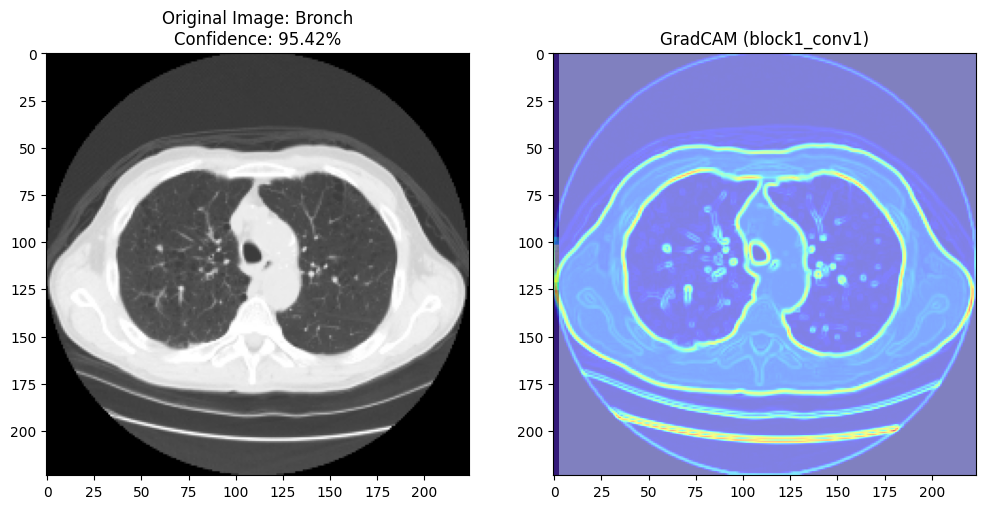

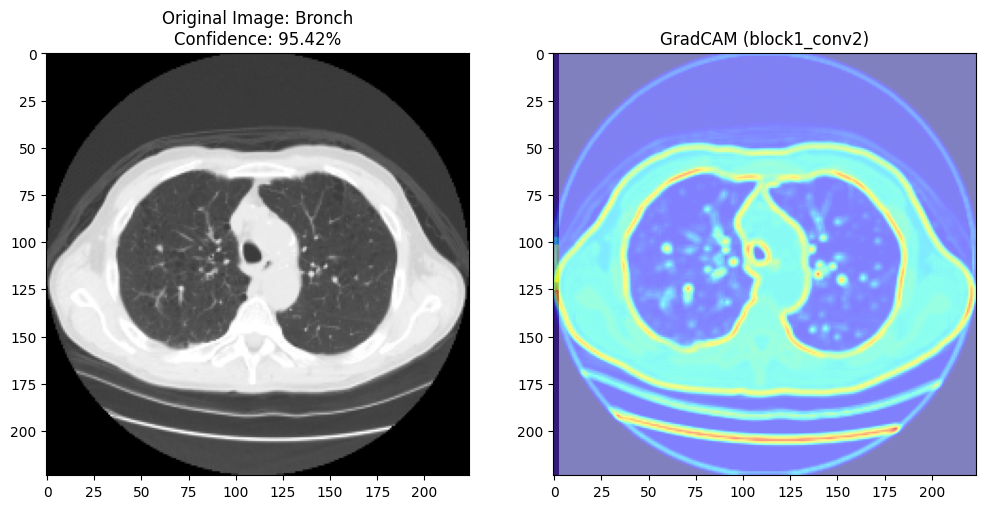

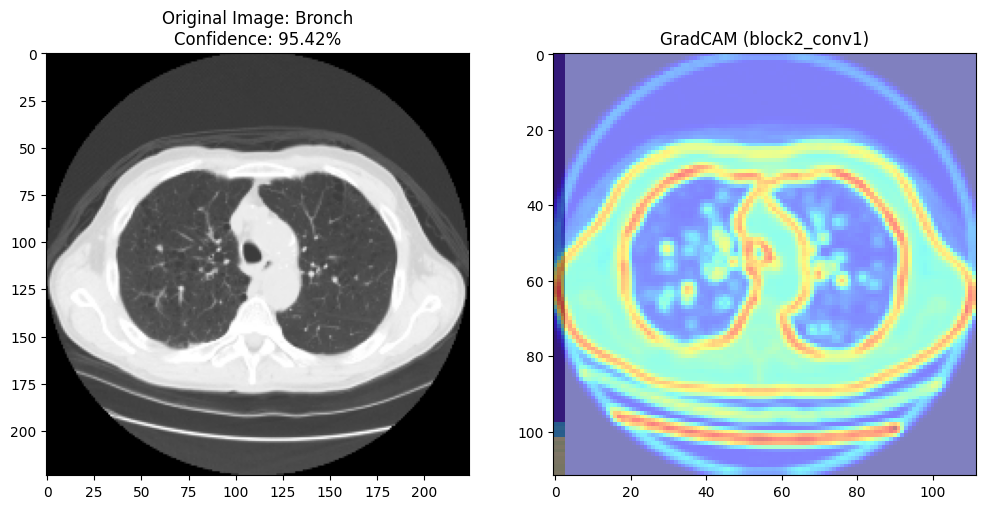

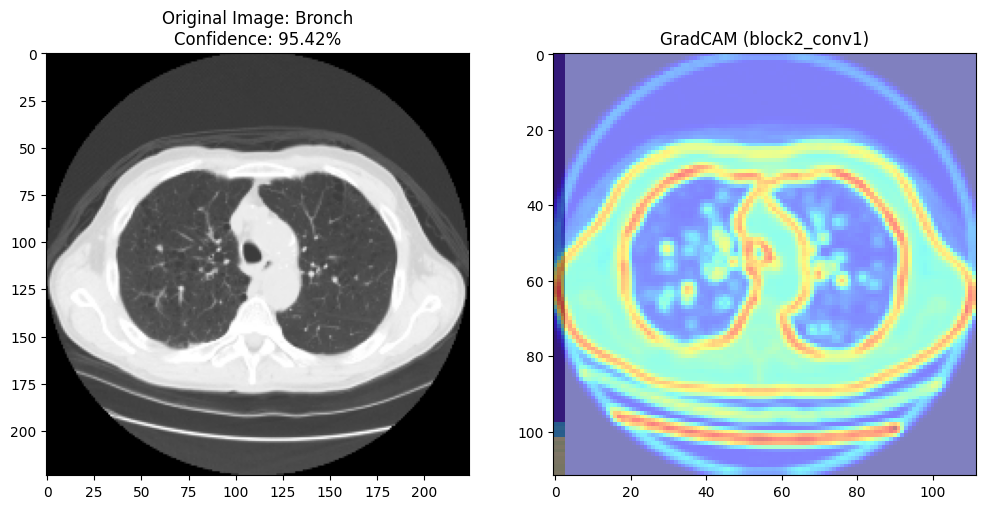

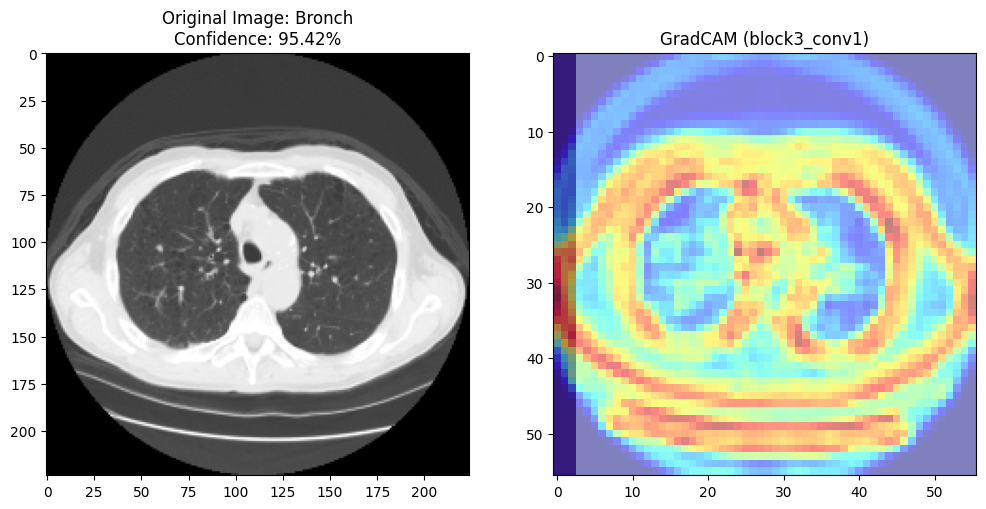

In [107]:
predictions = fine_tuned_model.predict(preprocess_input(np.expand_dims(test_image_array, axis=0)))

predicted_class_index = np.argmax(predictions[0])
confidence = predictions[0][predicted_class_index]

class_labels = ["Normal", "Nodule", "Inter", "Bronch", "Parenchyma", "Airspaces"]
predicted_label = class_labels[predicted_class_index]

print(f"Predicted class: {predicted_label}")
print(f"Confidence: {confidence:.2%}")

print(y_test[number])

for layer_name in layer_names:
    plot_gradcam(fine_tuned_model, test_image_array, layer_name, predicted_label, confidence)

In [91]:
y_pred = fine_tuned_model.predict(preprocess_input(X_test))

3/3 [==============================] - 9s 3s/step


In [92]:
y_pred_max_index = np.argmax(y_pred, axis=1)
y_pred_max_index = y_pred_max_index.astype(int)
y_pred_max_values = np.round(np.max(y_pred, axis=1), 2)

result_array = np.column_stack((y_pred_max_index, y_pred_max_values))

pred_vs = pd.DataFrame({"0": y_pred_max_index, "1": y_pred_max_values, "real": y_test})

def highlight_diff(row):
    if row["0"] != row["real"]:
        return ['color: red'] * len(row)
    else:
        return ['color: black'] * len(row)

styled_df = pred_vs.style.apply(highlight_diff, subset=["0", "real"], axis=1)

styled_df

,0,1,real
0,1,1.000000,3
1,0,1.000000,0
2,0,1.000000,0
3,2,1.000000,3
4,0,1.000000,0
5,4,0.730000,4
6,0,1.000000,0
7,0,1.000000,0
8,1,1.000000,2
9,0,1.000000,0


# Creating X and y for training and testing

In [67]:
X = np.concatenate((images_bronch, images_inter, images_nodule, images_parenchyma, images_normal), axis=0)
y = np.concatenate((labels_bronch, labels_inter, labels_nodule,  labels_parenchyma, labels_normal), axis=0)

#images_airspace,
#labels_airspace,

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4,

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [202]:
X_train.shape

(504, 224, 224, 3)

In [66]:
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [204]:
y_train.shape

(504,)

# Training the model

In [205]:
model = create_pretrained_vgg16_model()

In [206]:
es = EarlyStopping(patience = 5, restore_best_weights=True)

history = model.fit(X_train, y_train, 
          epochs=50,
          batch_size=64,
          validation_split = 0.3,
          callbacks=[es],
          verbose=1)

Epoch 1/50
6/6 [==============================] - 76s 13s/step - loss: 71.7844 - accuracy: 0.4574 - val_loss: 73.9138 - val_accuracy: 0.5855
Epoch 2/50
6/6 [==============================] - 75s 13s/step - loss: 37.1579 - accuracy: 0.6761 - val_loss: 17.5436 - val_accuracy: 0.6447
Epoch 3/50
6/6 [==============================] - 72s 13s/step - loss: 8.9500 - accuracy: 0.7528 - val_loss: 14.3681 - val_accuracy: 0.6842
Epoch 4/50
6/6 [==============================] - 73s 13s/step - loss: 3.2157 - accuracy: 0.8551 - val_loss: 11.4338 - val_accuracy: 0.6447
Epoch 5/50
6/6 [==============================] - 74s 13s/step - loss: 1.1364 - accuracy: 0.9148 - val_loss: 10.8728 - val_accuracy: 0.7039
Epoch 6/50
6/6 [==============================] - 73s 13s/step - loss: 0.7883 - accuracy: 0.9460 - val_loss: 9.3448 - val_accuracy: 0.6579
Epoch 7/50
6/6 [==============================] - 78s 14s/step - loss: 0.3731 - accuracy: 0.9631 - val_loss: 9.6287 - val_accuracy: 0.6776
Epoch 8/50
6/6 [====

KeyboardInterrupt: 

# Testing the model and displaying results

In [18]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    if title:
        fig.suptitle(title)

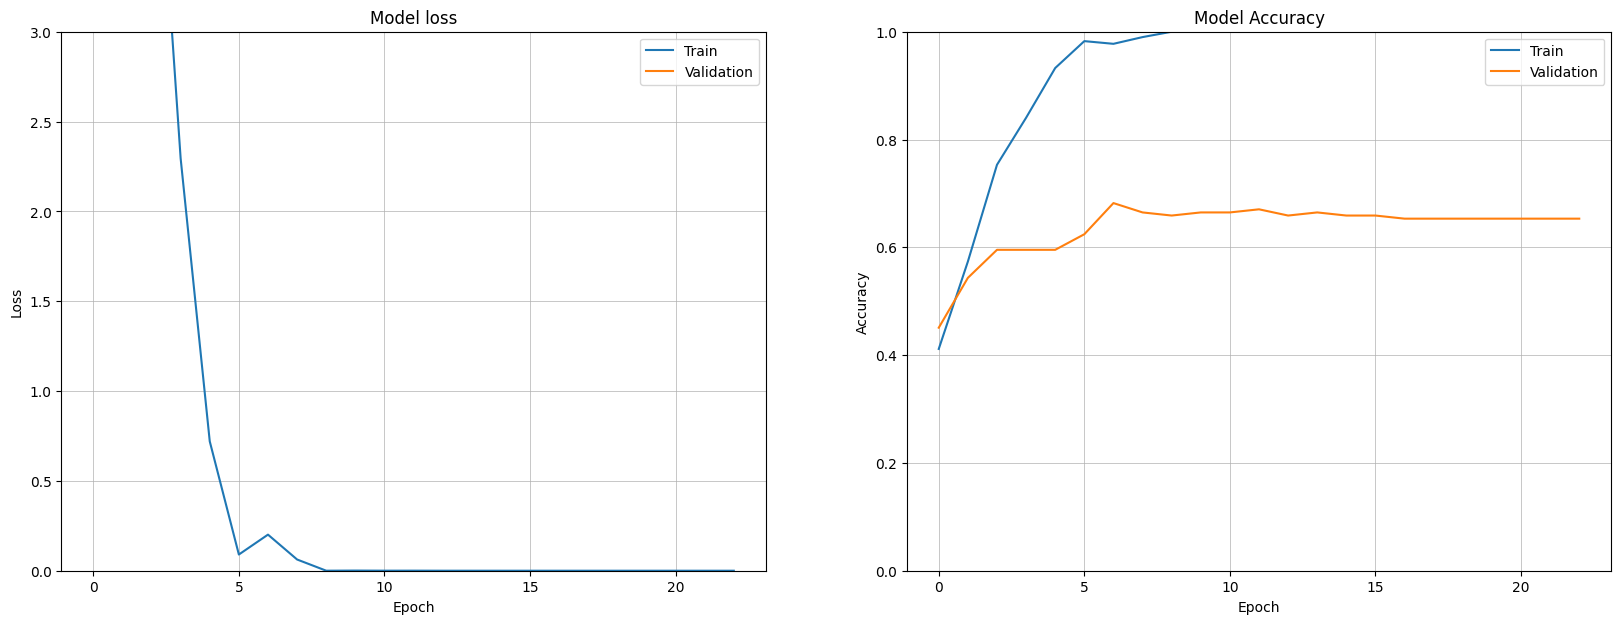

In [196]:
plot_loss_accuracy(history, title=None)

In [197]:
evaluation = model.evaluate(X_test, y_test)

8/8 [==============================] - 34s 4s/step - loss: 5.7229 - accuracy: 0.6260


In [186]:
print(f'Model accuracy is {round(evaluation[1]*100,2)} %')

Model accuracy is 74.19 %


ModuleNotFoundError: No module named 'pytorch'